In [ ]:
# Fazer as novas colunas
# Explicar que, como se trata de um dataset desbalanceado, temos que fazer com que o modelo aprenda a classificar corretamente
# a classe minoritária!

# Ter sempre o repositório sobre o Seaborn em mãos.

<h1 style='font-size:40px'> Employee Turnover Predicting Model</h1>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            This project aims to build a binary classifier that correctly predicts if a given employee is going to stay or quit the company.
        </li>
        <li> 
            The dataset used was encountered in a <a href='https://www.coursera.org/projects/employee-turnover-scikit-learn'>Coursera Guided Project</a>. Nonetheless, I've decided to produce my own solution to the case, which is different from the platform instructor's.
        </li>
    </ul>
</div>

<h2 style='font-size:30px'> Loading the Data</h2>

In [44]:
import pandas as pd
import numpy as np

# Since I am looking to create more columns to the DF, I'll modify the maximum number of columns that can be displayed.
pd.set_option('max_columns', None)

# Importing the employee data.
employee_data = pd.read_csv('employee_data.csv')
employee_data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [47]:
# Searching for anomalies in the data. All features do not present any null value and have its proper data type assigned.
employee_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   quit                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


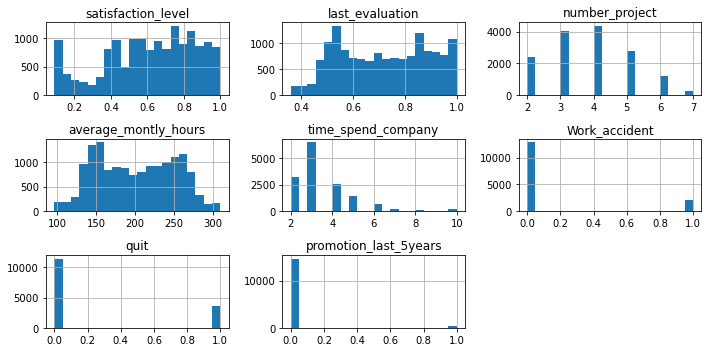

In [54]:
# Plotting a histograms frame looking for outliers.
employee_data.hist(bins=20, figsize=(10,5));
plt.tight_layout()

<div> 
    <ul style='font-size:20px'> 
        <li> 
            The number of people who've spent more than 7 years in the enterprise looks proportionately very small. It could be a potential indicator for disconsidering them in model training. However, when we directly check the dataset, we can see that more than 350 workers are in accordance to such condition. It would be adequate to make an algorithm that neglects the reality of such number of employees? I don't think so.
        </li>
    </ul>
</div>

In [63]:
# The well-experienced people will be kept in the dataset.
print(len(employee_data[employee_data.time_spend_company>7]))

376


<h2 style='font-size:30px'> Training and Test Sets</h2>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Since salary is one of the main aspects considered when someone is deciding to stay or leave their enterprise, I'll attempt to maintain the proportions of such feature. Fortunately, that is already labeled as categories so we don't need to encode any of its values.
        </li>
    </ul>
</div>

In [70]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(employee_data, employee_data.salary):
    train = employee_data.loc[train_index]
    test = employee_data.loc[test_index]

<h2 style='font-size:30px'> Exploratory Analysis on the Training Data</h2>

<h3 style='font-size:30px;font-style:italic'> Adding new stats</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Before diving into the data examination, it is interesting to use the data we already have in order to generate new stats that might be prove useful to our models.
        </li>
        <li> 
            The new columns to be added are:
            <ul style='list-style-type:lower-alpha'>
                <li> No of projects per years of work.</li>
                <li> Harmonic mean between the satisfaction levels and last evaluation.</li>
            </ul>
        </li>
    </ul>
</div>

In [137]:
# Criar aqui as novas colunas!
train.head(1)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary
11263,0.98,0.98,4,170,10,0,0,0,IT,medium


<AxesSubplot:xlabel='quit', ylabel='count'>

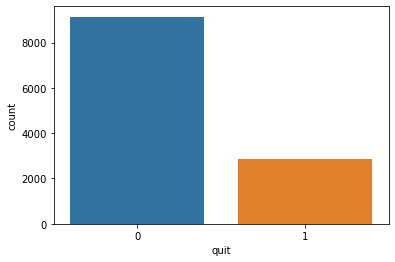

In [138]:
sns.countplot(data=train, x='quit')

<h3 style='font-size:30px;font-style:italic'> Densities of staying or quitting occurences according to satisfaction and salary</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            The violin plot below exposes, among every salary category, the densities of quitting and staying occurences for every satisfaction degree measured.
        </li>
        <li> 
            In all cases, employees with contentment levels lower than 50% tend to abandon the company.
        </li>
    </ul>
</div>

<AxesSubplot:xlabel='salary', ylabel='satisfaction_level'>

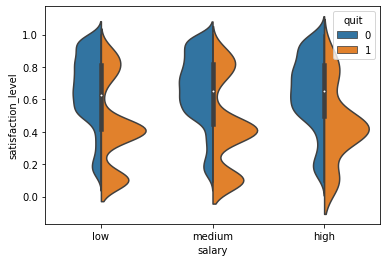

In [140]:
sns.violinplot(data=train, x='salary', y='satisfaction_level', hue='quit',split=True, order=['low', 'medium', 'high'])

<h3 style='font-size:30px;font-style:italic'> Statisfaction Levels per Department and Salary</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Seeing the tendencies of satisfacton degrees accordingly to the company's area and their employees' salary value.
        </li>
    </ul>
</div>

In [75]:
# Sorting by 'accounting' so the index order could be ['low', 'medium', 'high']
satisfact1 = pd.pivot_table(data = train, index='salary', columns='department', values='satisfaction_level').sort_values(by='accounting')

<AxesSubplot:xlabel='department', ylabel='salary'>

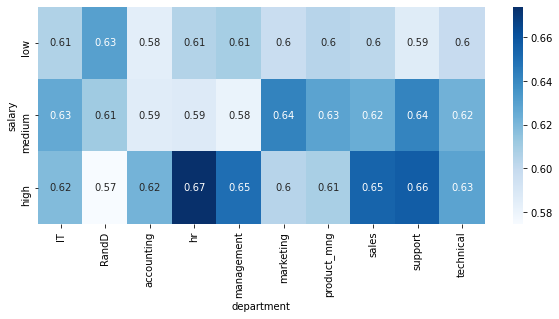

In [84]:
# Comentar o heatmap
# Notar a escala dos valores das cores. Não há nenhum departamento com menos de 0.5 de satisfação.
# Notar que certos departamentos possuem os funcionários com salário médios com as maiores satisfações.

# Em RandD, quanto maior o salário, menos satisfeito está o funcionário!
import seaborn as sns
plt.figure(figsize=(10,4))
sns.heatmap(satisfact1, cmap='Blues', annot=True)

In [87]:
employee_data.groupby('quit')['satisfaction_level'].mean()

quit
0    0.666810
1    0.440098
Name: satisfaction_level, dtype: float64